In [1]:
import numpy as np  
import pandas as pd  
import matplotlib.pyplot as plt 
from utils.filefinder import find_file
import re 
import seaborn as sns

#Einlesen des Reecoomended Albums Datensatz
df= pd.read_json(find_file("famousArtists.json"))  # get dataframe

#Funktionen 
def age_of_death(lifespan):
    lifespan_new=re.findall(r'\d{4}-\d{4}', lifespan)
    if len(lifespan_new)>0:
        lifespan_new = lifespan_new[0].split('-')
        age = int(lifespan_new[1])-int(lifespan_new[0])
    else:
        age=None
    return age

def alter_groupe(alter):
    if alter<20.0:
        alters_groupe = 'unter 20'
    elif (alter >=20.0) and (alter<=40.0):
        alters_groupe = '20-40'
    elif (alter >=40.0) and (alter<=60.0):
        alters_groupe = '40-60'
    elif (alter >=60.0) and (alter<=80.0):
        alters_groupe = '60-80'
    elif (alter>60.0):
        alters_groupe = 'über 80'
    else:
        alters_groupe=None
    return alters_groupe

def age_of_birth(lifespan):
    lifespan_new=re.findall(r'\d{4}-\d{4}', lifespan)
    if len(lifespan_new)>0:
        lifespan_new = lifespan_new[0].split('-')
        age_of_birth= lifespan_new[0]
    else:
        age_of_birth=None
    return age_of_birth

        
#Erstellen der lifespan und Age of death Spalte
df['Lebensdauer']=df['lifespan'].apply(lambda x: age_of_death(x))
df['Alters_groupe']=df['Lebensdauer'].apply(lambda y: alter_groupe(y))

#Erstellen neuer Zeilen mit jeweils nur einem Genre pro Künstler
data= df.assign(genres = df.genres.str.split(',')).explode('genres') 
data['genres'] = data['genres'].str.replace("[^a-zA-Z]+", "", regex = True) 

#Löschen aller Gruppen
data=data[data['isGroup']==0]

#Einlesen des Reecoomended Albums Datensatz
df2= pd.read_json(find_file("recomAlbums.json"))  # get dataframe
df2=df2[['artist','score','year']]

#Erstellen neuer Zeilen mit jeweils nur einem Artist pro Album
df2= df2.assign(artist = df2.artist.str.split('+')).explode('artist')
df2= df2.assign(artist = df2.artist.str.split(',')).explode('artist') 
df2= df2.assign(artist = df2.artist.str.split('/')).explode('artist') 
df2= df2.assign(artist = df2.artist.str.split('&')).explode('artist') 

#Ertsllen einer neuen Spalte mit dem Top score pro Künstler
df2= df2.groupby(["artist", "year"])["score"].agg(Top_score='max')
df2 = df2.reset_index()            # d2 = recomAlbums grouped by artists (max score)
df3= data.dropna()         #df3 = famous dead 

#Inner join der beiden Dataframes
df4=df3.merge(df2, on = "artist",how='inner')

df4['Age_of_birth']=df4['lifespan'].apply(lambda x: age_of_birth(x))
df4=df4.dropna()
df4["year"] = df4["year"].astype(int)
df4["Age_of_birth"] = df4['Age_of_birth'].astype(int)
df4['Höhepunkt der Karriere']=df4.year-df4.Age_of_birth

#Neues Datenset mit Median der höhepunkt der Karriere nach Genres
data4 = df4.groupby("genres")["Höhepunkt der Karriere"].agg(Höhepunkt_der_Karriere='median')
data4=pd.DataFrame(data4)
data4 = data4.reset_index() 
data1 = df4.groupby("genres")["Lebensdauer"].agg(Lebensdauer='median')
data1 = data1.reset_index() 

#Merge von data1 und data4
data5=data1.merge(data4, on='genres')
data5=pd.melt(data5,id_vars=['genres'],var_name='Kategorie', value_name='Alter')

found data/famousArtists.json
found data/recomAlbums.json


Text(0.48, 1.02, 'Abbildung der durchschnittlichen Lebensdauer und des Alters bei dem Höhepunkt der Karriere der Musiker nach Genre')

<Figure size 2160x2160 with 0 Axes>

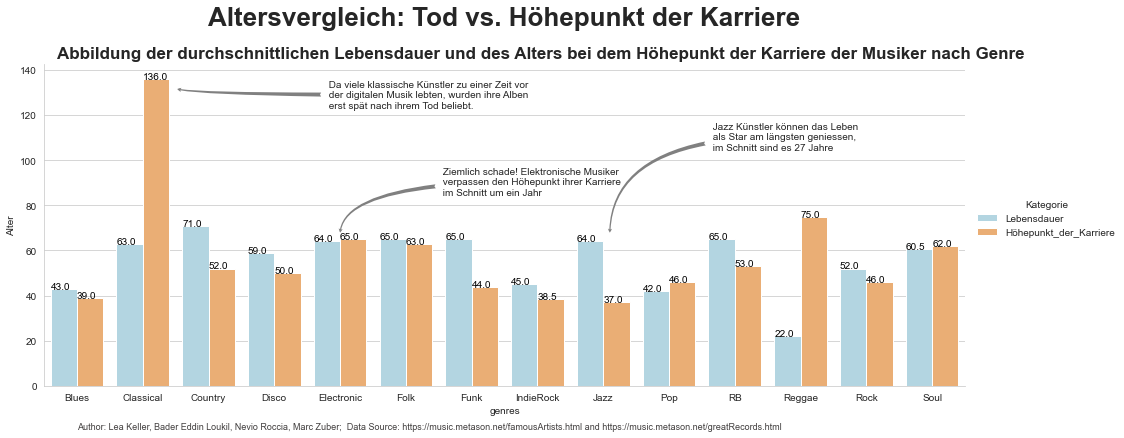

In [2]:
#Erstellen der Graphik 
sns.set_style("whitegrid")
plt.figure(figsize=(30,30))
ax=sns.catplot(x='genres',y='Alter', data = data5 , kind='bar',ci="sd",hue='Kategorie',aspect=2.7,palette=['#abd9e9','#fdae61'])

plt.text(
    0,
    -19,
    "Author: Lea Keller, Bader Eddin Loukil, Nevio Roccia, Marc Zuber;  Data Source: https://music.metason.net/famousArtists.html and https://music.metason.net/greatRecords.html",
    fontsize=9,
    fontfamily="sans-serif",
    color = "#434040"
)

ai = ax.facet_axis(0,0)
for p in ai.patches:
    ai.text(p.get_x() , 
            p.get_height() , 
            '{}'.format(p.get_height()), 
            color='black', rotation='horizontal')

# Bildunterschrift hinzufügen
ai.annotate(' Da viele klassische Künstler zu einer Zeit vor \n der digitalen Musik lebten, wurden ihre Alben \n erst spät nach ihrem Tod beliebt.', 
            xy=(1.5, 132),  xycoords='data',
            xytext=(150, -20), textcoords='offset points',
            arrowprops=dict(arrowstyle="fancy",
                            fc="grey", ec="none",
                            connectionstyle="angle3,angleA=0,angleB=-90"))

ai.annotate(' Jazz Künstler können das Leben \n als Star am längsten geniessen, \n im Schnitt sind es 27 Jahre', 
            xy=(8.1, 67),  xycoords='data',
            xytext=(100, 85), textcoords='offset points',
            arrowprops=dict(arrowstyle="fancy",
                            fc="grey", ec="none",
                            connectionstyle="angle3,angleA=0,angleB=-90"))

ai.annotate(' Ziemlich schade! Elektronische Musiker \n verpassen den Höhepunkt ihrer Karriere \n im Schnitt um ein Jahr', 
            xy=(4, 67),  xycoords='data',
            xytext=(100, 40), textcoords='offset points',
            arrowprops=dict(arrowstyle="fancy",
                            fc="grey", ec="none",
                            connectionstyle="angle3,angleA=0,angleB=-90"))

#Titel und Subtitel
plt.title('Altersvergleich: Tod vs. Höhepunkt der Karriere',fontsize=26,y=1.1,x=0.5,fontweight="bold")
plt.suptitle('Abbildung der durchschnittlichen Lebensdauer und des Alters bei dem Höhepunkt der Karriere der Musiker nach Genre', 
             fontweight="semibold",fontsize=17,y=1.02, x= 0.48)

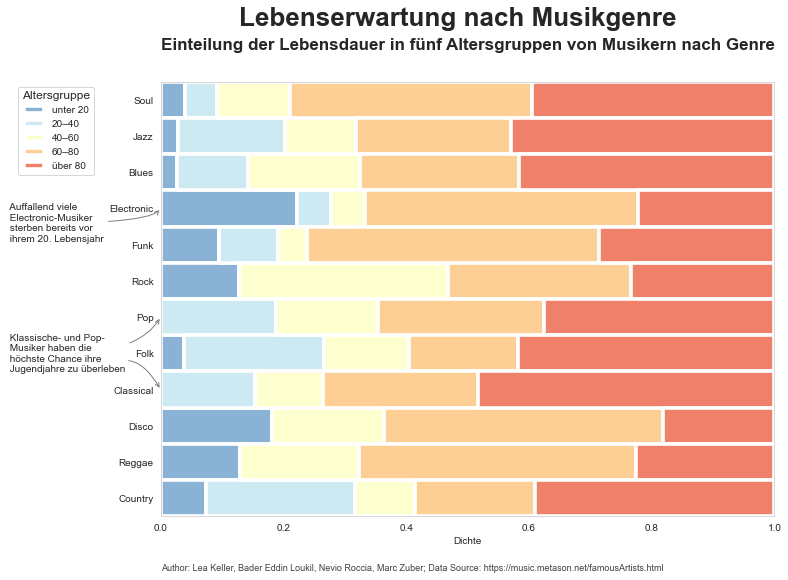

In [3]:
sns.set_style("whitegrid",{"grid.linestyle": ""})
plt.figure(figsize=(11,8))

# Nur Genres die nach einem full-join der letzten Aufgabe noch Einträge haben werden beachtet
df3=df3[df3['genres'].isin(['Electronic','Folk','Funk','Jazz','Rock','Soul','Blues','Classical','Country','Disco','Indie Rock','Pop','R&B','Reggae'])]

# Plot mit Legenden erstellen
p = sns.histplot(df3, y = "genres", hue="Alters_groupe", stat = "density", multiple = "fill", palette = "RdYlBu")
plt.legend(labels =["unter 20","20–40", "40–60", "60–80","über 80"], title = "Altersgruppe", fontsize = "10", title_fontsize = "12", bbox_to_anchor=(-0.1, 1))
plt.suptitle("Lebenserwartung nach Musikgenre", fontsize = 26, weight = 'bold', y = 1.01)
plt.title("Einteilung der Lebensdauer in fünf Altersgruppen von Musikern nach Genre", fontsize=17, weight='semibold', y =1.06)
p.set_xlabel("Dichte")
p.set_ylabel("")

# Pfeile und Beschreibungen
p.annotate(' Auffallend viele \n Electronic-Musiker \n sterben bereits vor \n ihrem 20. Lebensjahr', xy=(0, 3), xytext=(-0.25, 3.9),
            arrowprops=dict(color='grey', arrowstyle="->", connectionstyle="angle3,angleA=0,angleB=-120"))

p.annotate(' Klassische- und Pop- \n Musiker haben die \n höchste Chance ihre \n Jugendjahre zu überleben', xy=(0, 6), xytext=(-0.25, 7.5),
            arrowprops=dict(color='grey', arrowstyle="->", connectionstyle="angle3,angleA=0,angleB=-120"))

p.annotate('', xy=(0, 8), xytext=(-0.0555, 7.2),
            arrowprops=dict(color='grey', arrowstyle="->", connectionstyle="angle3,angleA=0,angleB=-60"))

# Bildunterschrift
plt.text(0,13, "Author: Lea Keller, Bader Eddin Loukil, Nevio Roccia, Marc Zuber; Data Source: https://music.metason.net/famousArtists.html",
         fontsize=9, fontfamily="sans-serif", color = "#434040")

plt.show()